In [119]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
max_depth = 5

In [120]:
fields = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
data_wine = pd.read_csv(r"winequality-red.csv", sep=";")
print(len(data_wine.index))
data_wine.head()

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [121]:
data_cars = pd.read_csv("auto-mpg.csv")
data_cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [122]:
def prepare_data(which='Wine'):
    if which == "Wine":
        ## split in test and train set
        mask = np.random.rand(len(data_wine)) < 0.8
        X_train = data_wine[mask]
        X_test = data_wine[~mask]

        y_train = pd.Series(X_train['fixed acidity'])
        y_test = pd.Series(X_test['fixed acidity'])

        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        X_train = X_train.drop(columns=['fixed acidity'])
        X_train = X_train.reset_index(drop=True)

        X_test = X_test.drop(columns=['fixed acidity'])
        X_test = X_test.reset_index(drop=True)
        
        print("X train:",len(X_train)," Y train:",len(y_train)," X Test: ",len(X_test)," Y test: ",len(y_test))

        return X_train,y_train,X_test,y_test
    
    elif which == "Cars":
        ## split in test and train set
        mask = np.random.rand(len(data_cars)) < 0.8
        X_train = data_cars[mask]
        X_test = data_cars[~mask]

        y_train = pd.Series(X_train['mpg'])
        y_test = pd.Series(X_test['mpg'])

        
        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)


        ## drop everything but horsepower and weight

        X_train = X_train.drop(columns=["cylinders", "displacement","acceleration","model year","origin","car name"])
        X_test = X_test.drop(columns=["cylinders", "displacement","acceleration","model year","origin","car name"])

        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)

        
        return X_train,y_train,X_test,y_test
    

def get_full_dataset(which="Wine"):
    if which == 'Wine':
        X = data_wine
        y = pd.Series(X['fixed acidity'])
        y = y.reset_index(drop=True)
        X = X.drop(columns=['fixed acidity'])
        X = X.reset_index(drop=True)

        return X,y
    
    elif which == 'Cars':
        X = data_cars
        y = pd.Series(X['mpg'])
        y = y.reset_index(drop=True)
        X = X.drop(columns=["cylinders", "displacement","acceleration","model","year","origin","car name"])
        X = X.reset_index(drop=True)

        return X,y

### Fiecare nod va fi un dictionar de forma : {feature: f , separation_treshold: t, node_left (<= t) : nl, node_right (> t) : nr}

In [123]:
## Pandas Series
def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 

In [124]:

def transform_list(l):
    '''
    Transforma {10,12,13,44,50} in {11,12.5,28.5,47}
    '''
    tbr = []
    
    for i in range(len(l)-1):
        mean = (l[i] + l[i+1]) / 2
        tbr += [mean]

    return tbr

def find_best_rule(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        ## transform to couple means
        if type(thresholds[0]) == int or type(thresholds[0]) == float:
            thresholds = transform_list(thresholds)
        
        ## if list of strings should return each one

        # thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = rss(y_left, y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold, 'RSS': min_rss}

In [125]:
def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) <= 5:
        return {'prediction': np.mean(y_train), 'RSS':np.var(y_train)}
    
    rule = find_best_rule(X_train, y_train)
    left_ix = X_train[rule['feature']] < rule['threshold']
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

In [126]:
def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

In [127]:
def get_leaves(rules):
    leaves = []
    def get_leaves_inner(rules):
        nonlocal leaves
        ## daca nu e frunza
        if rules.get('prediction',None) == None:
            ## vizitez copii
            get_leaves_inner(rules['left'])
            get_leaves_inner(rules['right'])
        else:
            leaves += [rules]

    get_leaves_inner(rules)
    return leaves


def RSS_tree(rules):
    ## is leaf
    if rules.get('prediction',None) != None:
        return rules['RSS']

    leaves = get_leaves(rules)
    return np.mean([leaf['RSS'] for leaf in leaves])

def get_prune_prediction(node):
    leaves = get_leaves(node)
    return np.mean([leaf['prediction'] for leaf in leaves])

def C_alpha(rules,alpha=1):
    leaves = get_leaves(rules)
    return RSS_tree(rules) + alpha * len(leaves) 

In [128]:
def evaluate(X, y,rules):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    print(preds)
    return r2_score(preds, y)

In [129]:
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

def RMSE(y,t):
    return np.sqrt(mean_squared_error(y,t))


In [130]:
X_train,y_train,X_test,y_test = prepare_data()

y_train.head()

X train: 1263  Y train: 1263  X Test:  336  Y test:  336


0     7.4
1     7.8
2    11.2
3     7.4
4     7.4
Name: fixed acidity, dtype: float64

In [131]:

X_train,y_train,X_test,y_test = prepare_data()
rules = split(X_train, y_train, 0, max_depth)

# print(rules)
# print("\n\n")
# print(get_leaves(rules))
# print("\n\n")
# print(RSS_tree(rules))
# print("C ALPHA:",C_alpha(rules))

X train: 1304  Y train: 1304  X Test:  295  Y test:  295


In [132]:

y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

results.head()

y_predicted_np = y_predicted.to_numpy()
y_test_np = y_test.to_numpy()

print("MSE is:",mean_squared_error(y_predicted_np,y_test_np))
print("RMSE is:",RMSE(y_predicted_np,y_test_np))

MSE is: 0.6761378867915652
RMSE is: 0.8222760405068149


Trebuie arborele initial construit peste training sau peste tot?

Ce predictie o sa aiba nodul ramas dupa taiere? media cumva?


### Pruning

In [133]:
def get_node_minimum_g(rules):

    min_g = 1e6
    min_t = None

    def get_node_minimum_g_inner(rules):
        nonlocal min_g
        nonlocal min_t

        ## leaf node
        if rules.get('prediction',None) != None:
            return
            
        g_score = (rules['RSS'] - RSS_tree(rules)) / (len(get_leaves(rules)) - 1)

        if g_score < min_g:
            min_g = g_score
            min_t = rules

        if rules.get('prediction',None) == None:
            get_node_minimum_g_inner(rules['left'])
            get_node_minimum_g_inner(rules['right'])

    get_node_minimum_g_inner(rules)
    return min_g,min_t


## o sa inlocuiasca subtree ce are ca parinte pe node cu node si predictia media predictiilor tuturor copiilor frunza
def eq_nodes(node1,node2):

    if node1.get('prediction',None) != None and node2.get('prediction',None) == None:
        return False

    if node2.get('prediction',None) != None and node1.get('prediction',None) == None:
        return False

    ## shouldnt enter here
    ## both are leaves
    
    if node1.get('prediction',None) != None and node2.get('prediction',None) != None:
        print("Shouldn't be here !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return None 

    return node1['feature'] == node2['feature'] and node1['threshold'] == node2['threshold'] and node1['RSS'] == node2['RSS']


## sper ca modifica dictionarul
def prune_node(rules,node):
    
    ## leaf
    if rules.get('prediction',None) != None:
        return

    left_child = rules.get('left',None)
    right_child = rules.get('right',None)

    if left_child != None:
        if eq_nodes(left_child,node):
            ## the left child is the node to be replaced
            new_RSS = RSS_tree(left_child)
            new_prediction = get_prune_prediction(left_child)
            rules['left'] = {'prediction': new_prediction,'RSS': new_RSS}
            return
        
        prune_node(left_child,node)

    if right_child != None:
        if eq_nodes(right_child,node):
            ## the right child is the node to be replaced
            new_RSS = RSS_tree(right_child)
            new_prediction = get_prune_prediction(right_child)
            rules['right'] = {'prediction': new_prediction,'RSS': new_RSS}
        

        prune_node(right_child,node)

## has only right and left children which each have 2 predictions    
def is_in_final_form(rules):
    left_child = rules['left']
    right_child = rules['right']

    cond_left = left_child['left'].get('prediction',None) != None and left_child['right'].get('prediction',None) != None 
    cond_right = right_child['left'].get('prediction',None) != None and right_child['right'].get('prediction',None) != None 

    return cond_left and cond_right


In [134]:

## RMSE scores per tree
scores = []
alphas = []
RSSs = []

X_train,y_train,X_test,y_test = prepare_data()
rules = split(X_train, y_train, 0, max_depth)

# print(rules)
# print("\n\n")


y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

scores += [RMSE(y_predicted.to_numpy(),y_test.to_numpy())]
RSSs += [RSS_tree(rules)]

while not is_in_final_form(rules):
    alpha,node = get_node_minimum_g(rules)
    alphas += [alpha]
    prune_node(rules,node)

    ## now rules are pruned

    y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

    results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

    scores += [RMSE(y_predicted.to_numpy(),y_test.to_numpy())]
    RSSs += [RSS_tree(rules)]

    

# print(alphas)
# print(scores)
# print(rules)


X train: 1248  Y train: 1248  X Test:  351  Y test:  351


### Values of alpha | Wine dataset

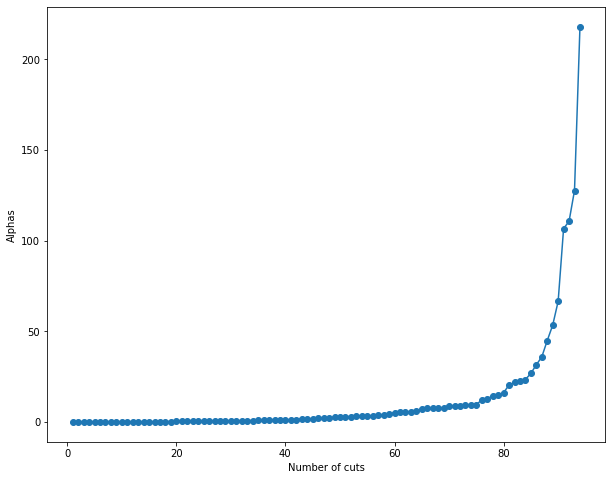

In [135]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("Alphas")
plt.scatter([i+1 for i in range(len(alphas))],alphas)
plt.plot([i+1 for i in range(len(alphas))],alphas)
plt.show()


### RMSE vs number of cuts | Wine Dataset

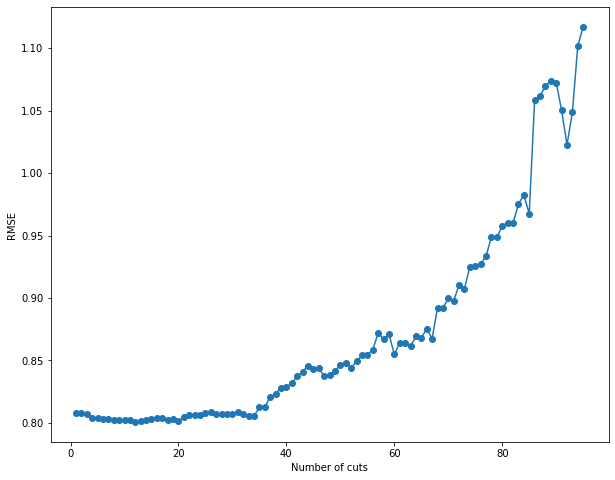

In [136]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RMSE")
plt.scatter([i+1 for i in range(len(scores))],scores)
plt.plot([i+1 for i in range(len(scores))],scores)
plt.show()


#### Se observa deci ca se pot face taieturi pentru a scadea din dimensiunea arborelui care nu cresc RMSE foarte mult ( sau chiar il scad )

### RSS per tree

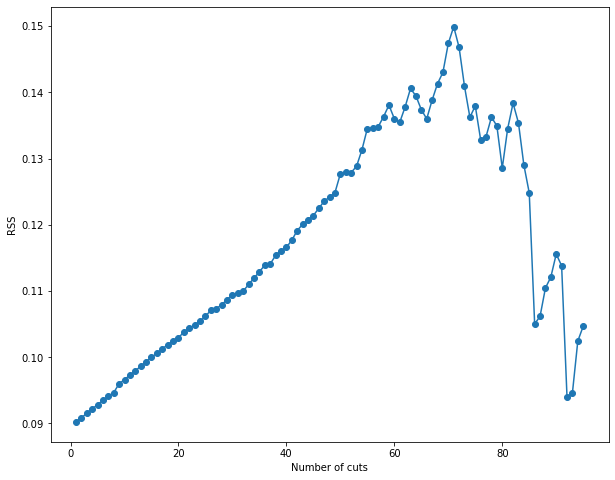

In [137]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RSS")
plt.scatter([i+1 for i in range(len(RSSs))],RSSs)
plt.plot([i+1 for i in range(len(RSSs))],RSSs)
plt.show()

In [139]:
## TODO: fa si pentru celalalt dataset cu valori discrete
max_depth = 5
## RMSE scores per tree
scores = []
alphas = []
RSSs = []
X_train,y_train,X_test,y_test = prepare_data(which="Cars")
rules = split(X_train, y_train, 0, max_depth)

# print(rules)
# print("\n\n")


y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

scores += [RMSE(y_predicted.to_numpy(),y_test.to_numpy())]
RSSs += [RSS_tree(rules)]

while not is_in_final_form(rules):
    alpha,node = get_node_minimum_g(rules)
    alphas += [alpha]
    prune_node(rules,node)

    ## now rules are pruned

    y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

    results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

    scores += [RMSE(y_predicted.to_numpy(),y_test.to_numpy())]
    RSSs += [RSS_tree(rules)]
    

# print(alphas)
# print(scores)
# print(rules)


### Values of alpha | Car dataset

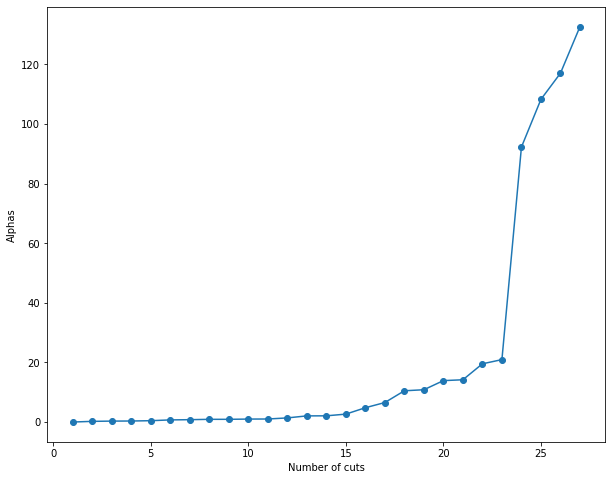

In [140]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("Alphas")
plt.scatter([i+1 for i in range(len(alphas))],alphas)
plt.plot([i+1 for i in range(len(alphas))],alphas)
plt.show()


### RMSE vs number of cuts | Car Dataset

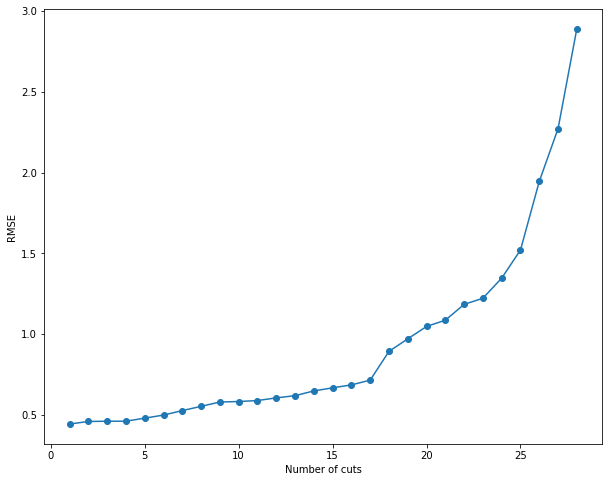

In [141]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RMSE")
plt.scatter([i+1 for i in range(len(scores))],scores)
plt.plot([i+1 for i in range(len(scores))],scores)
plt.show()


### RSS per tree

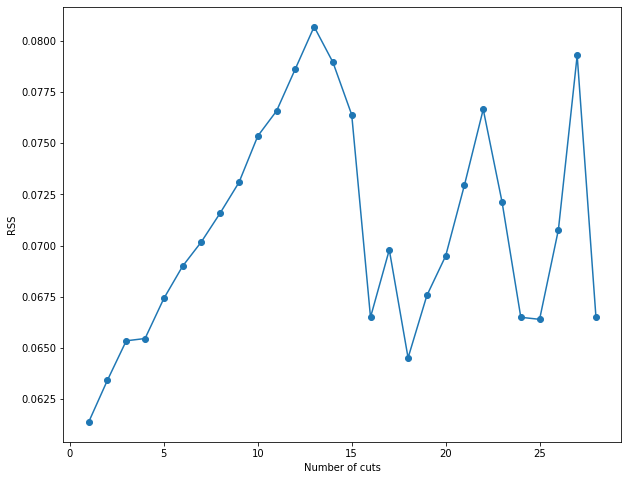

In [142]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RSS")
plt.scatter([i+1 for i in range(len(RSSs))],RSSs)
plt.plot([i+1 for i in range(len(RSSs))],RSSs)
plt.show()